
Predicting Earnings from census data

The United States government periodically collects demographic information by conducting a census.

In this problem, we are going to use census information about an individual to predict how much a person earns -- in particular, whether the person earns more than $50,000 per year. This data comes from the UCI Machine Learning Repository.

The file census.csv contains 1994 census data for 31,978 individuals in the United States.

The dataset includes the following 13 variables:

    age = the age of the individual in years
    workclass = the classification of the individual's working status (does the person work for the federal government, work for the local government, work without pay, and so on)
    education = the level of education of the individual (e.g., 5th-6th grade, high school graduate, PhD, so on)
    maritalstatus = the marital status of the individual
    occupation = the type of work the individual does (e.g., administrative/clerical work, farming/fishing, sales and so on)
    relationship = relationship of individual to his/her household
    race = the individual's race
    sex = the individual's sex
    capitalgain = the capital gains of the individual in 1994 (from selling an asset such as a stock or bond for more than the original purchase price)
    capitalloss = the capital losses of the individual in 1994 (from selling an asset such as a stock or bond for less than the original purchase price)
    hoursperweek = the number of hours the individual works per week
    nativecountry = the native country of the individual
    over50k = whether or not the individual earned more than $50,000 in 1994



In [2]:
census = read.csv("census.csv")

In [3]:
set.seed(2000)

In [4]:
library(caTools)

In [5]:
split = sample.split(census$over50k,SplitRatio = 0.6)

In [6]:
Train = subset(census,split == TRUE)
Test = subset(census,split == FALSE)

In [7]:
nrow(Train)
nrow(Test)

[1] 19187

[1] 12791

In [8]:
LogCensus = glm(over50k~., data = Train, family = binomial)

Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

In [9]:
summary(LogCensus)


Call:
glm(formula = over50k ~ ., family = binomial, data = Train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.1065  -0.5037  -0.1804  -0.0008   3.3383  

Coefficients: (1 not defined because of singularities)
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                              -8.658e+00  1.379e+00  -6.279 3.41e-10
age                                       2.548e-02  2.139e-03  11.916  < 2e-16
workclass Federal-gov                     1.105e+00  2.014e-01   5.489 4.03e-08
workclass Local-gov                       3.675e-01  1.821e-01   2.018 0.043641
workclass Never-worked                   -1.283e+01  8.453e+02  -0.015 0.987885
workclass Private                         6.012e-01  1.626e-01   3.698 0.000218
workclass Self-emp-inc                    7.575e-01  1.950e-01   3.884 0.000103
workclass Self-emp-not-inc                1.855e-01  1.774e-01   1.046 0.295646
workclass State-gov                       4

In [10]:
LogPredTest = predict(LogCensus, newdata = Test, type="response")

Warning message:
In predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == : prediction from a rank-deficient fit may be misleading

In [11]:
t = table(Test$over50k, LogPredTest>0.5)

In [12]:
t

        
         FALSE TRUE
   <=50K  9051  662
   >50K   1190 1888

In [13]:
sum(diag(t))/sum(t)

[1] 0.8552107

In [14]:
table(Test$over50k)


 <=50K   >50K 
  9713   3078 

In [15]:
9713/(9713+3078)

[1] 0.7593621

In [17]:
library("ROCR")

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [18]:
ROCRPredTst = prediction(LogPredTest,Test$over50k)

In [20]:
as.numeric(performance(ROCRPredTst,"auc")@y.values)

[1] 0.9061598

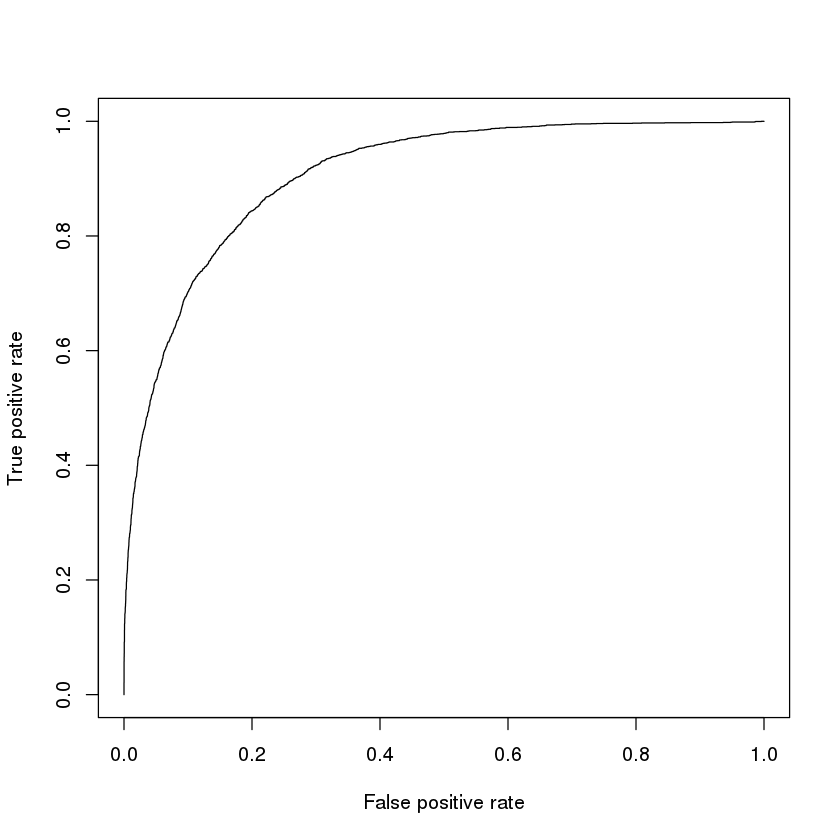

In [38]:

perfLog = performance(ROCRPredTst,"tpr","fpr")
plot(perfLog)

In [22]:
library("rpart")
library("rpart.plot")
censusTree = rpart(over50k~., data = Train, method = "class")

Warning message:
: package ‘rpart.plot’ was built under R version 3.3.0

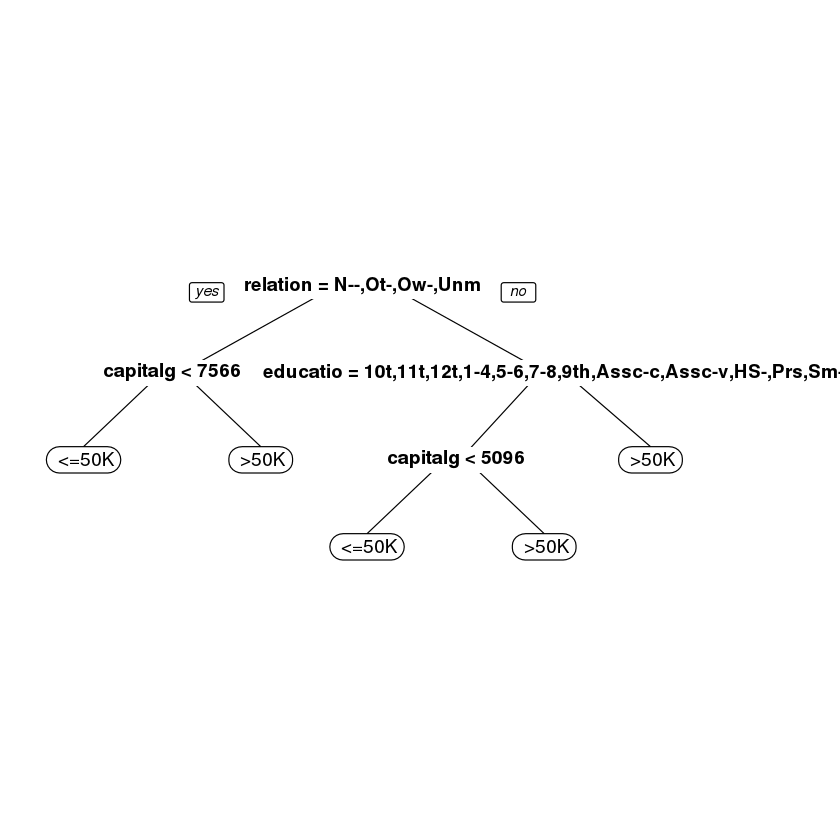

In [23]:
prp(censusTree)

#### What is the accuracy of the model on the testing set? Use a threshold of 0.5. (You can either add the argument type="class", or generate probabilities and use a threshold of 0.5 like in logistic regression.)

In [24]:
PredTreeTest = predict(censusTree, newdata = Test, type = "class")

In [25]:
t = table(Test$over50k, PredTreeTest)

In [26]:
t

        PredTreeTest
          <=50K  >50K
   <=50K   9243   470
   >50K    1482  1596

In [27]:
sum(diag(t))/sum(t)

[1] 0.8473927

In [28]:
PredTreeTestProb = predict(censusTree, newdata = Test)

In [30]:
str(PredTreeTestProb)

 num [1:12791, 1:2] 0.279 0.279 0.949 0.697 0.697 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:12791] "2" "5" "7" "8" ...
  ..$ : chr [1:2] " <=50K" " >50K"


In [31]:
PredTreeTestProb_g50k = PredTreeTestProb[,2]

In [32]:
PredTreeTestProb_g50k[1:10]

2          5          7          8         11         12         13 
0.72050176 0.72050176 0.05098572 0.30271934 0.30271934 0.72050176 0.05098572 
        14         15         19 
0.05098572 0.30271934 0.05098572

In [34]:
ROCRTree = prediction(PredTreeTestProb_g50k, Test$over50k)

In [35]:
as.numeric(performance(ROCRTree,"auc")@y.values)

[1] 0.8470256

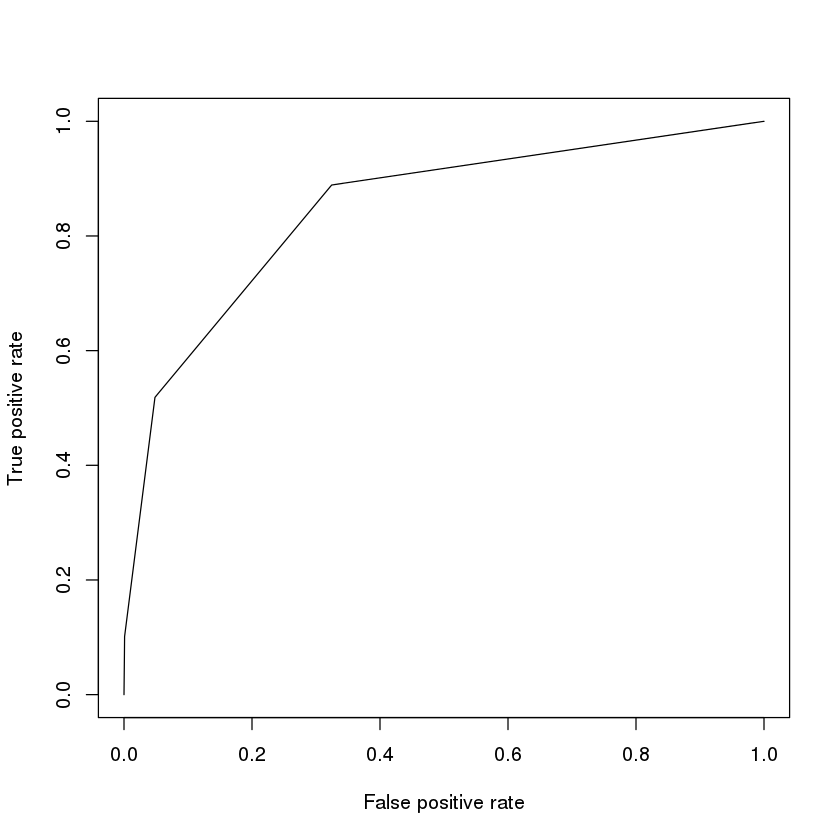

In [40]:
perfTree = performance(ROCRTree,"tpr","fpr")
plot(perfTree)

Before building a random forest model, we'll down-sample our training set. While some modern personal computers can build a random forest model on the entire training set, others might run out of memory when trying to train the model since random forests is much more computationally intensive than CART or Logistic Regression. For this reason, before continuing we will define a new training set to be used when building our random forest model, that contains 2000 randomly selected obervations from the original training set. Do this by running the following commands in your R console 


In [41]:
set.seed(1)

In [43]:
trainSmall = Train[sample(nrow(Train), 2000), ]

In [45]:
set.seed(1)
library("randomForest")
censusForest = randomForest(over50k~., data = trainSmall)

In [46]:
censusForestPredTest = predict(censusForest, newdata = Test)

In [47]:
summary(censusForestPredTest)

<=50K   >50K 
 11571   1220

In [48]:
t = table(Test$over50k, censusForestPredTest)
t

        censusForestPredTest
          <=50K  >50K
   <=50K   9586   127
   >50K    1985  1093

In [49]:
sum(diag(t))/sum(t)

[1] 0.8348839

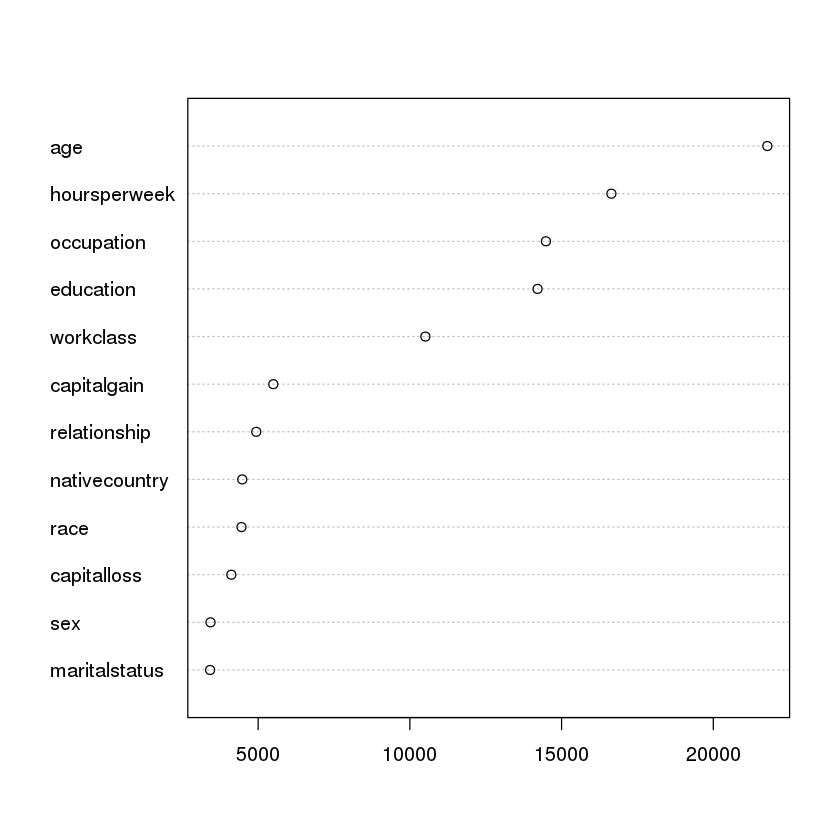

In [50]:
vu = varUsed(censusForest, count=TRUE)

vusorted = sort(vu, decreasing = FALSE, index.return = TRUE)

dotchart(vusorted$x, names(censusForest$forest$xlevels[vusorted$ix]))

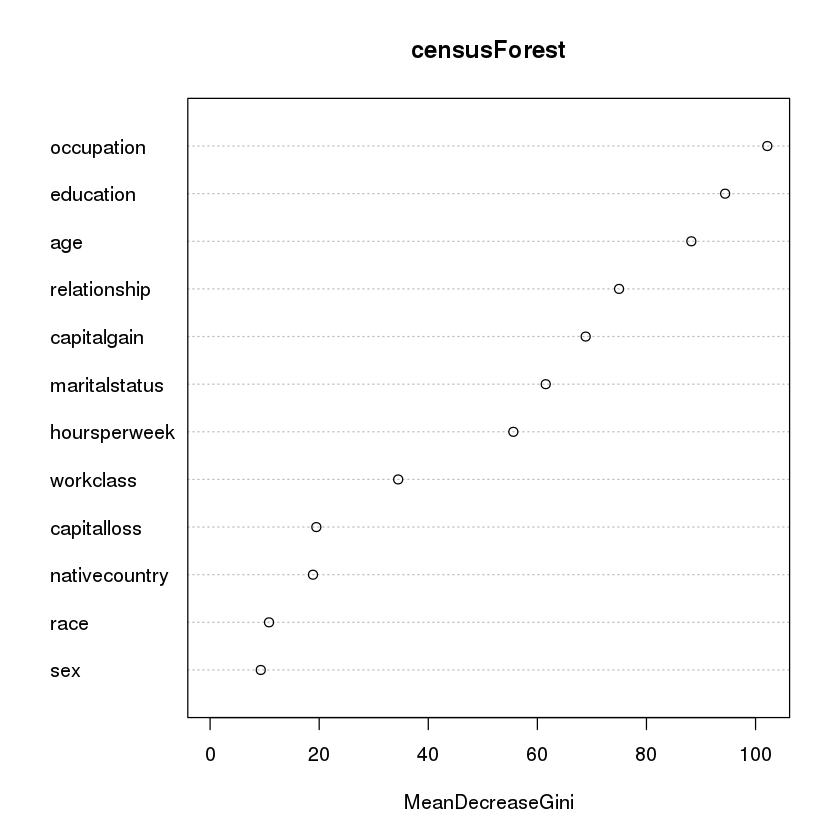

In [51]:
varImpPlot(censusForest)

In [59]:
set.seed(2)

In [60]:
library(caret)
library(e1071)

In [61]:
numFolds = trainControl(method = "cv",number = 10)

In [65]:
str(numFolds)

List of 25
 $ method           : chr "cv"
 $ number           : num 10
 $ repeats          : num 1
 $ search           : chr "grid"
 $ p                : num 0.75
 $ initialWindow    : NULL
 $ horizon          : num 1
 $ fixedWindow      : logi TRUE
 $ verboseIter      : logi FALSE
 $ returnData       : logi TRUE
 $ returnResamp     : chr "final"
 $ savePredictions  : logi FALSE
 $ classProbs       : logi FALSE
 $ summaryFunction  :function (data, lev = NULL, model = NULL)  
 $ selectionFunction: chr "best"
 $ preProcOptions   :List of 3
  ..$ thresh : num 0.95
  ..$ ICAcomp: num 3
  ..$ k      : num 5
 $ sampling         : NULL
 $ index            : NULL
 $ indexOut         : NULL
 $ timingSamps      : num 0
 $ predictionBounds : logi [1:2] FALSE FALSE
 $ seeds            : logi NA
 $ adaptive         :List of 4
  ..$ min     : num 5
  ..$ alpha   : num 0.05
  ..$ method  : chr "gls"
  ..$ complete: logi TRUE
 $ trim             : logi FALSE
 $ allowParallel    : logi TRUE


In [62]:
cartGrid = expand.grid( .cp = seq(0.002,0.1,0.002)) 

In [64]:
dim(cartGrid)

[1] 50  1

In [66]:
train(over50k~.,data = Train, method = "rpart", trControl = numFolds, tuneGrid = cartGrid)

CART 

19187 samples
   12 predictors
    2 classes: ' <=50K', ' >50K' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 17268, 17269, 17268, 17268, 17269, 17269, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa       Accuracy SD   Kappa SD  
  0.002  0.8515658  0.55758898  0.0052948552  0.01739909
  0.004  0.8476566  0.55353089  0.0066966577  0.02355150
  0.006  0.8444252  0.53388285  0.0065980275  0.02317270
  0.008  0.8441646  0.53439869  0.0064904574  0.02340138
  0.010  0.8443210  0.53574983  0.0064991617  0.02413215
  0.012  0.8443210  0.53574983  0.0064991617  0.02413215
  0.014  0.8443210  0.53574983  0.0064991617  0.02413215
  0.016  0.8434351  0.53116984  0.0049698138  0.02002302
  0.018  0.8405163  0.51397907  0.0063520005  0.03039022
  0.020  0.8395783  0.50605490  0.0053905706  0.02178219
  0.022  0.8391090  0.50179921  0.0053072840  0.01935313
  0.024  0.8391090  0.50179921  0.0053072840  0.01935313
  0.026  0.

In [67]:
censusCPTree = rpart(over50k~., data = Train, method = "class",cp = 0.002)

In [68]:
censusCPTreePredTest = predict(censusCPTree, newdata = Test, type = "class")

In [69]:
summary(censusCPTreePredTest)

<=50K   >50K 
 10418   2373

In [70]:
t=table(Test$over50k,censusCPTreePredTest)

In [71]:
t

        censusCPTreePredTest
          <=50K  >50K
   <=50K   9178   535
   >50K    1240  1838

In [72]:
sum(diag(t))/sum(t)

[1] 0.8612306

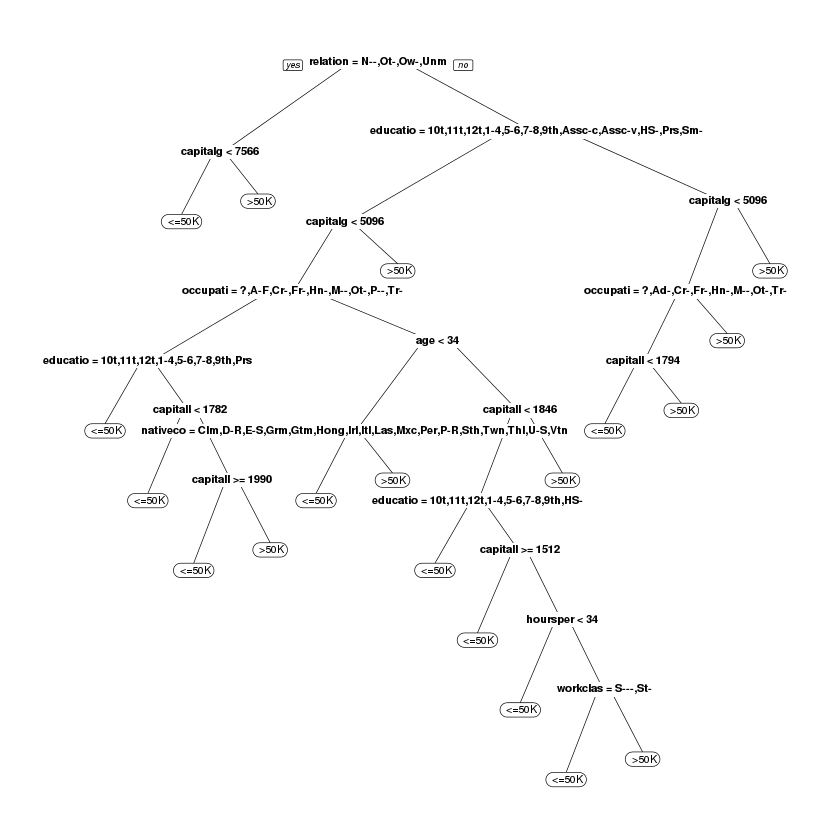

In [73]:
prp(censusCPTree)